In [106]:
#import libraries
import re 
import nltk 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [107]:
## Reading data from csv file
df=pd.read_csv("../content/flipkart_com-ecommerce_sample.csv", na_values=["No rating available"])
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,NaN,NaN,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,NaN,NaN,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,NaN,NaN,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,NaN,NaN,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,NaN,NaN,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,7179d2f6c4ad50a17d014ca1d2815156,2015-12-01 10:15:43 +0000,http://www.flipkart.com/walldesign-small-vinyl...,WallDesign Small Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE7KFJAKSTDY9G,1500.0,730.0,"[""http://img6a.flixcart.com/image/wall-decorat...",False,Buy WallDesign Small Vinyl Sticker for Rs.730 ...,NaN,NaN,WallDesign,"{""product_specification""=>[{""key""=>""Number of ..."
19996,71ac419198359d37b8fe5e3fffdfee09,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Stickers Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE9F5URNQGJCGH,1429.0,1143.0,"[""http://img6a.flixcart.com/image/sticker/z/g/...",False,Buy Wallmantra Large Vinyl Stickers Sticker fo...,NaN,NaN,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
19997,93e9d343837400ce0d7980874ece471c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/elite-collection-mediu...,Elite Collection Medium Acrylic Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE7VAYDKQZEBSD,1299.0,999.0,"[""http://img5a.flixcart.com/image/sticker/b/s/...",False,Buy Elite Collection Medium Acrylic Sticker fo...,NaN,NaN,Elite Collection,"{""product_specification""=>[{""key""=>""Number of ..."
19998,669e79b8fa5d9ae020841c0c97d5e935,2015-12-01 10:15:43 +0000,http://www.flipkart.com/elite-collection-mediu...,Elite Collection Medium Acrylic Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE8YSVEPPCZ42Y,1499.0,1199.0,"[""http://img5a.flixcart.com/image/sticker/4/2/...",False,Buy Elite Collection Medium Acrylic Sticker fo...,NaN,NaN,Elite Collection,"{""product_specification""=>[{""key""=>""Number of ..

In [108]:
df.info()  # we will get the total no of entries and no of columns in the given dataset   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           1849 non-null   float64
 12  overall_rating           1849 non-null   float64
 13  brand                    14136 non-null  object 
 14  product_specifications

In [ ]:
df.shape    ## this will show how much big our dataset is i.e (no. of entries, no of columns)

(20000, 15)

**Data Cleaning and Pre-Processing**

In [ ]:
df['product_category_tree']=df['product_category_tree'].map(lambda x:x.strip('[]'))
df['product_category_tree']=df['product_category_tree'].map(lambda x:x.strip('"'))
df['product_category_tree']=df['product_category_tree'].map(lambda x:x.split('>>'))

In [ ]:
#delete unwanted columns as we don't need them
del_list=['product_url','image',"is_FK_Advantage_product"]
df=df.drop(del_list,axis=1)

In [ ]:

## this will give you the number of enteries and no of columns in your new database 
## After removing the unwanted columns, now in new dataset we have 12 columns only 
df.info()          


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uniq_id                 20000 non-null  object 
 1   crawl_timestamp         20000 non-null  object 
 2   product_name            20000 non-null  object 
 3   product_category_tree   20000 non-null  object 
 4   pid                     20000 non-null  object 
 5   retail_price            19922 non-null  float64
 6   discounted_price        19922 non-null  float64
 7   description             19998 non-null  object 
 8   product_rating          1849 non-null   float64
 9   overall_rating          1849 non-null   float64
 10  brand                   14136 non-null  object 
 11  product_specifications  19986 non-null  object 
dtypes: float64(4), object(8)
memory usage: 1.8+ MB


In [ ]:
## Now we will Drop data points with duplicate products

smd=df.copy()
# drop duplicate produts
smd.drop_duplicates(subset ="product_name", 
                     keep = "first", inplace = True)
smd.shape

## This will give us the number of enteries with no column which are not having duplicate products.

(12676, 12)

In [ ]:
def preprocess_string(str_arg):
    '''
    input: str_arg --> Takes string to clean
    output: cleaned_str --> Gives back cleaned string
    This fuction cleans the text in the mentioned ways as comments after the line.This has been copied from some other kernel.

    '''
    cleaned_str=re.sub('[^a-z\s]+',' ',str_arg,flags=re.IGNORECASE) #every char except alphabets is replaced
    cleaned_str=re.sub('(\s+)',' ',cleaned_str) #multiple spaces are replaced by single space
    cleaned_str=cleaned_str.lower() #converting the cleaned string to lower case
    
    return cleaned_str # Returning the preprocessed string in tokenized form

In [ ]:
## This code block is for reading and cleaning data.
## In this we are only taking 5 categories

import_df = pd.read_csv('../content/flipkart_com-ecommerce_sample.csv')
# Reading relevant data
import_df['product_category_tree'] = import_df['product_category_tree'].apply(lambda x : x.split('>>')[0][2:].strip())
# Category processing. (Check data to understand)
top_fiv_gen = list(import_df.groupby('product_category_tree').count().sort_values(by='uniq_id',ascending=False).head(5).index)
# Taking only top 5 categories for example sake
processed_df = import_df[import_df['product_category_tree'].isin(top_fiv_gen)][['product_category_tree','description']]
# Selecting only relevant columns
processed_df['description'] = processed_df['description'].astype('str').apply(preprocess_string)
# Cleaning strings
cat_list = list(processed_df['product_category_tree'].unique())
# Creating a list of categories for later use
print(cat_list)


# Printing the list of top 5 categories
le = preprocessing.LabelEncoder()
category_encoded=le.fit_transform(processed_df['product_category_tree'])
processed_df['product_category_tree'] = category_encoded
# Encoding the product category

['Clothing', 'Footwear', 'Automotive', 'Mobiles & Accessories', 'Jewellery']


In [ ]:

## This code block is for spliting train test data

X_train, X_test, y_train, y_test = train_test_split(processed_df['description'],processed_df['product_category_tree'],test_size=0.2)

In [ ]:
## This code block is for converting the training data to vectorized form


vect = CountVectorizer(stop_words = 'english')
# Removing stop words
X_train_matrix = vect.fit_transform(X_train) 
# Converting the train data

In [ ]:
## This code block is for training vectorized data and predicting & scoring test data


clf=MultinomialNB()
# Defining model
clf.fit(X_train_matrix, y_train)
# Fitting to multinomial NB model 
print(clf.score(X_train_matrix, y_train))
# Scoring the trained model (Expected to be above 95 percent)
X_test_matrix = vect.transform(X_test) 
# Converting the test data
print (clf.score(X_test_matrix, y_test))
# Scoring for the test data
predicted_result=clf.predict(X_test_matrix)
print(classification_report(y_test,predicted_result))
# Printing score 

0.9929206926241271
0.9896710022953328
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       199
           1       1.00      1.00      1.00      1214
           2       0.96      0.99      0.98       220
           3       0.98      1.00      0.99       733
           4       1.00      0.92      0.96       248

    accuracy                           0.99      2614
   macro avg       0.99      0.98      0.98      2614
weighted avg       0.99      0.99      0.99      2614



In [ ]:
## This code block is for converting the training data to Tf-Idf form

vectorizer = TfidfVectorizer(stop_words = 'english')
# Removing stop words
X_train_tfidf = vectorizer.fit_transform(X_train)
# Converting the train data

In [ ]:
## This code block is for training, predicting & scoring test data


clf2=MultinomialNB()
# Defining model
clf2.fit(X_train_tfidf, y_train)
# Fitting to multinomial NB model 
print(clf2.score(X_train_tfidf, y_train))
# Scoring the trained model (Expected to be above 95 percent)
X_test_tfidf = vectorizer.transform(X_test) 
# Converting the test data
print (clf2.score(X_test_tfidf, y_test))
# Printing score 

0.9935903568353582
0.9892884468247896


In [ ]:
## Testing Block: Test your sting. Replace the 'car' string to test

le.inverse_transform(clf.predict(vect.transform(['car'])))

array(['Automotive'], dtype=object)

**Conclusion**


Naive bayes is working very well for this dataset, and also it is providing us the accuracy of more than 99%

In [100]:
# create new variable: discount_percent

df["discount_percent"] = ((df.retail_price - df.discounted_price)*100)/df.retail_price
df.discount_percent.head()

0    62.062062
1    29.576764
2    50.050050
3    61.802575
4     4.545455
Name: discount_percent, dtype: float64

In [ ]:
## Creating a function to extract the level of product category from Product category tree

**Create a function to extract nth level of product category from the product category tree**


The product categories are stored in the variable "product_category_tree". The following function is used to extract the product categories at a specified level in the tree.

In [89]:
def get_nth_category(dataframe, level=1):
    """extract the level-n product category from the product category tree"""
    
    if level == 1:
        category = dataframe.product_category_tree.apply(lambda x: re.split(" >> ", x)[0]).str[2:]
    else:
        category = dataframe.product_category_tree.apply(lambda x: re.split(" >> ", x)[level:(level+1)])
    
    category = category.replace("[]", "[EMPTY_LEVEL]")  # this line does not work! Suggestions welcome :)

    return category

In [94]:
df["primary_category"] = get_nth_category(df, level=1)
df["secondary_category"] = get_nth_category(df, level=2)

In [91]:
print(df.primary_category.head(5), "\n\n")
print(df.secondary_category.head(5))

0        Clothing
1       Furniture
2        Footwear
3        Clothing
4    Pet Supplies
Name: primary_category, dtype: object 


0    [Lingerie, Sleep & Swimwear]
1            [Sofa Beds & Futons]
2                    [Ballerinas]
3    [Lingerie, Sleep & Swimwear]
4              [Skin & Coat Care]
Name: secondary_category, dtype: object


In [95]:
# check missing values in the product's ratings column

print("Missing value percentage", "\n\nProduct rating: ", round(df.product_rating.isnull().sum()*100/df.shape[0], 2), "%",
      "\nOverall rating: ", round(df.overall_rating.isnull().sum()*100/df.shape[0], 2), "%")

Missing value percentage 

Product rating:  90.76 % 
Overall rating:  90.76 %


In [101]:
# groupby using primary_category

groupby_df = pd.DataFrame(df.groupby("primary_category").agg({"discount_percent": [np.mean],"primary_category": ["count"]}))

groupby_df.columns = ["_".join(col) for col in groupby_df.columns]
groupby_df = groupby_df.sort_values(by = ["primary_category_count"], ascending=False)
groupby_df = groupby_df[groupby_df.primary_category_count > 80]

In [102]:
# reset index to flatten column names as output by the groupby object

groupby_df.reset_index(inplace=True)

In [103]:
print(groupby_df.head())
print(groupby_df.info())
print(groupby_df.describe())

        primary_category  discount_percent_mean  primary_category_count
0               Clothing              45.070525                    6198
1              Jewellery              40.889934                    3531
2               Footwear              36.268531                    1227
3  Mobiles & Accessories              50.994470                    1099
4             Automotive              54.650991                    1012
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   primary_category        20 non-null     object 
 1   discount_percent_mean   20 non-null     float64
 2   primary_category_count  20 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 608.0+ bytes
None
       discount_percent_mean  primary_category_count
count              20.000000               20.000000
mean               34.6

Text(0, 0.5, 'Product Category')

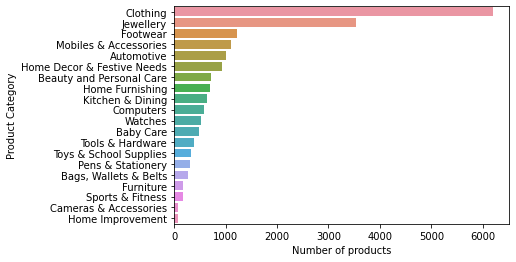

In [104]:
# product category vs product count

sns.barplot(data=groupby_df.sort_values(["primary_category_count"], ascending=False),
            y="primary_category", x = "primary_category_count")
plt.xlabel("Number of products")
plt.ylabel("Product Category")

Text(0, 0.5, 'Product Category')

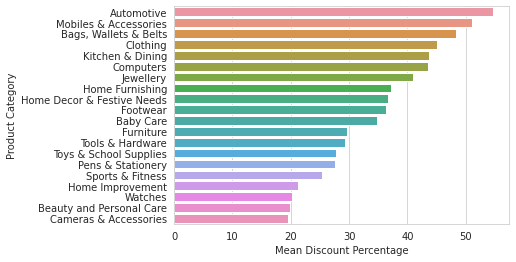

In [126]:
# product category vs category discounts

sns.barplot(data=groupby_df.sort_values(by = ["discount_percent_mean"], ascending=False), y="primary_category", x = "discount_percent_mean")
plt.xlabel("Mean Discount Percentage")
plt.ylabel("Product Category")